# RNN modeling

### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [2]:
daily = pd.read_csv('./datasets/london_smart_meters/ds_master.csv')

**set date column as index**

In [3]:
daily['day'] = pd.to_datetime(daily['Unnamed: 0'])
daily.set_index('day', inplace=True)
daily.drop(columns='Unnamed: 0', inplace=True)
daily.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday
day,,,,,,,,,,,,,,
2011-11-23,2.9660,3.654184,9.835,334,2.264165,90.385000,1.113,10.36,8.24,2.04,0.36,0.93,8.06,0
2011-11-24,4.8395,5.855170,19.046,922,3.909215,213.412000,2.019,12.93,9.71,4.04,0.41,0.89,10.64,0
2011-11-25,5.6890,7.196841,23.246,1383,4.962879,303.993000,2.283,13.03,7.01,5.02,0.48,0.79,12.38,0
2011-11-26,8.3345,10.153053,33.868,1773,7.115718,420.976000,3.002,12.96,11.59,5.75,0.44,0.81,13.07,0
2011-11-27,7.4235,9.268396,35.484,1968,7.180928,444.883001,2.867,13.54,1.31,5.48,0.42,0.72,13.08,0


In [4]:
daily.drop(columns=['energy_std', 'energy_mean', 'energy_count']).head(3).round(2)

,energy_median,energy_max,energy_sum,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday
day,,,,,,,,,,,
2011-11-23,2.97,9.84,90.39,1.11,10.36,8.24,2.04,0.36,0.93,8.06,0
2011-11-24,4.84,19.05,213.41,2.02,12.93,9.71,4.04,0.41,0.89,10.64,0
2011-11-25,5.69,23.25,303.99,2.28,13.03,7.01,5.02,0.48,0.79,12.38,0


In [5]:
X = daily.loc[daily.index[290:-1],:].drop(columns='energy_sum')
y = daily.loc[daily.index[290:-1],'energy_sum'].values

In [6]:
X

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday
day,,,,,,,,,,,,,
2012-09-07,593.7740,795.136704,3283.953000,227989,644.175380,249.785,27.12,11.32,1.39,0.14,0.62,12.36,0
2012-09-08,620.8390,815.038278,3301.584997,227961,642.358898,262.225,27.78,16.93,2.97,0.22,0.67,12.20,0
2012-09-09,636.1965,851.021354,3424.486001,227766,678.194667,269.064,20.21,14.77,5.69,0.59,0.78,12.65,0
2012-09-10,631.8060,841.963338,3392.653998,228078,669.885056,264.297,17.82,8.24,4.84,0.37,0.62,13.18,0
2012-09-11,603.8730,815.402347,3353.844999,228057,659.612747,252.426,17.92,8.62,3.93,0.34,0.72,13.16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23,890.5955,1196.517223,4637.863002,239244,989.640912,307.110,11.94,7.99,7.10,0.66,0.76,12.33,0
2014-02-24,777.8235,1082.541351,4368.773002,239249,916.840358,288.544,14.23,8.25,5.02,0.50,0.74,13.00,0
2014-02-25,776.6520,1072.219838,4338.690001,238918,904.955967,291.155,11.43,4.17,5.69,0.62,0.78,12.09,0


### Check out a quick plot of some daily values

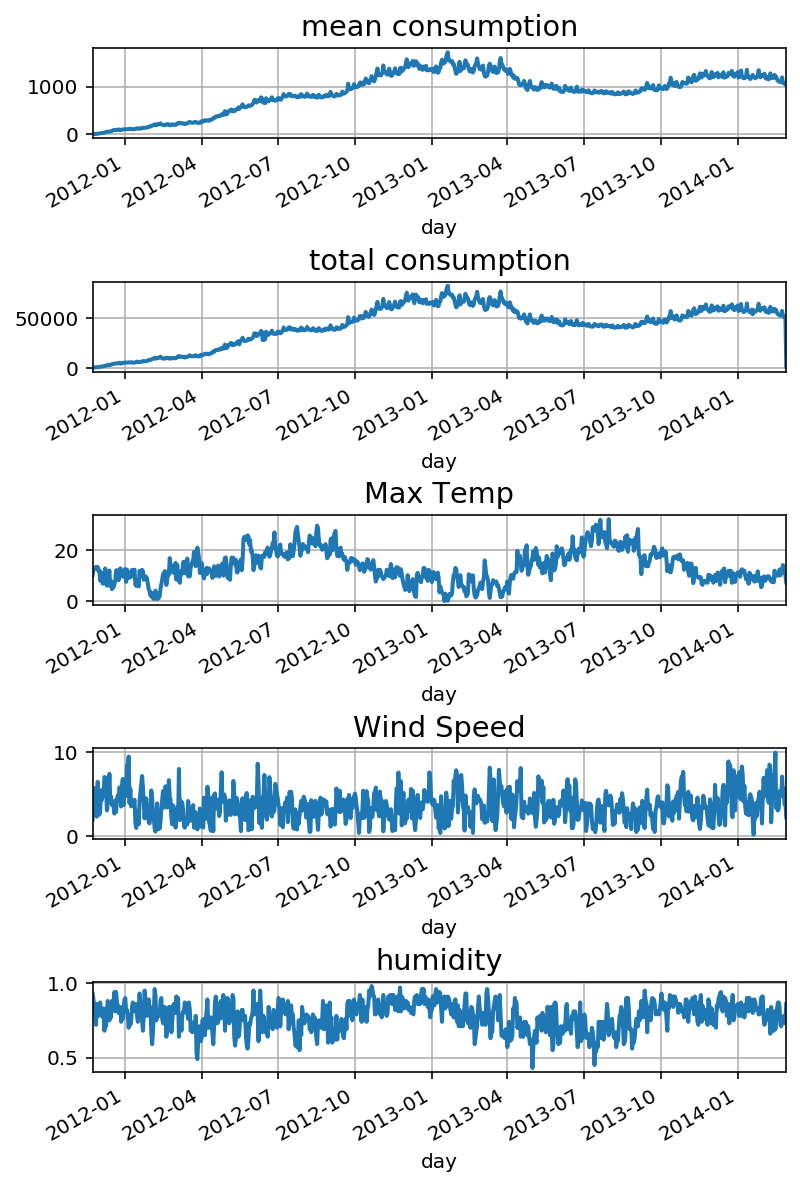

In [7]:
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (7, 10))
plt.style.use('bmh')
plt.tight_layout(pad=6)
ax = ax.ravel()

daily['energy_mean'].plot(title = 'mean consumption', ax=ax[0])
daily['energy_sum'].plot(title = 'total consumption', ax=ax[1])
daily['temperatureMax'].plot(title = 'Max Temp', ax=ax[2])
daily['windSpeed'].plot(title = 'Wind Speed', ax=ax[3])
daily['humidity'].plot(title = 'humidity', ax=ax[4])


### Train test split and scale

In [8]:
X = daily.drop(columns='energy_sum')
y = daily['energy_sum'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Convert data into series using TimeseriesGenerator

Create training and testing sequences with a length of 3 and batch size of 64

In [10]:
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 64)

test_seq = TimeseriesGenerator(X_test_sc, 
                                y_test, 
                                length = 3, 
                                batch_size = 64)

### Fit Model

Create an RNN with: 
* 2 GRU layers
* 2 hidden Dense layers
* 1 Dense output layer

In [12]:
from time import time

In [11]:
model = Sequential()

# 13 inputs is arbitrary, 
# (3, 13) is the the input tensor shape
model.add(GRU(13, input_shape=(3, 13),
             return_sequences=True))

model.add(GRU(13, 
              return_sequences=False))

model.add(Dense(6, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', 
              optimizer=Adam(),
              metrics=['mean_absolute_error'])

In [13]:
t0 = time()

hist = model.fit_generator(train_seq,
                           epochs = 500,
                           validation_data=test_seq,
                           verbose=0)

print(f'This took {round(((time() - t0)/60), 2)} minutes')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
This took 0.68 minutes


In [14]:
hist.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

### Plot the model performance

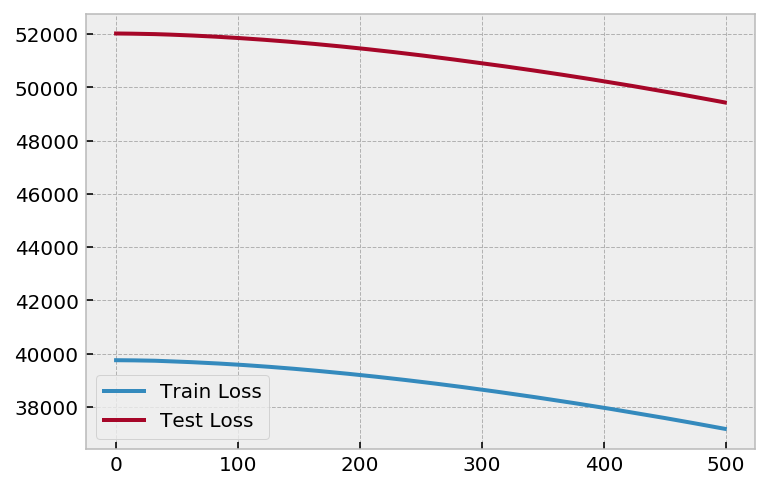

In [15]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend();

#### Clearly the model needs more epochs

### Try getting rid of the first 10 months of data in order to have consistent and stationary readings from all houses

In [16]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None): #, steps=1):
    
    plt.figure(figsize=(9, 6))
    
    # Iterate through each column name.
    for col in cols:
        df[col].plot()
    plt.legend()    
    
    # Generate title and labels.
    plt.title(title, fontsize=13)
    plt.xlabel(xlab, fontsize=11)
    plt.ylabel(ylab, fontsize=11)
    
    # Enlarge tick marks.
    #plt.yticks(fontsize=18)
    #plt.xticks(df.index[0::steps], fontsize=18);

In [17]:
daily.index[290]

Timestamp('2012-09-07 00:00:00')

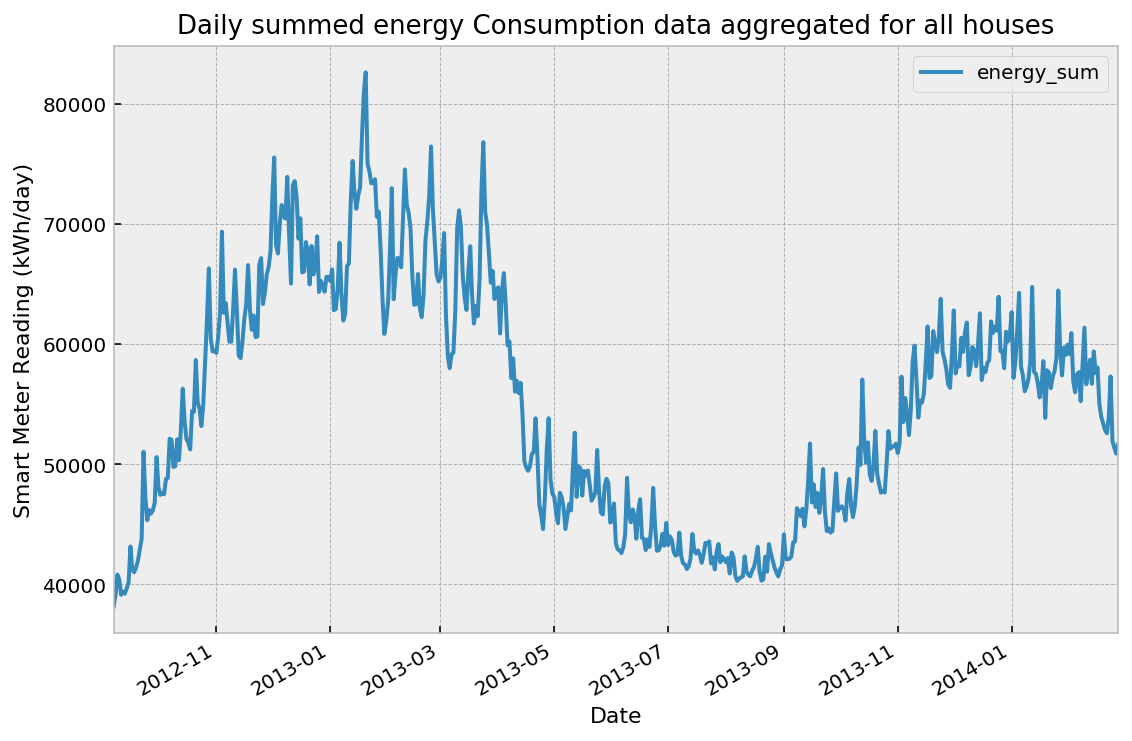

In [18]:
plot_series(df = daily.loc[daily.index[290:-1],:], 
            cols = ['energy_sum'], 
            title = 'Daily summed energy Consumption data aggregated for all houses', 
            xlab = 'Date',
            ylab = 'Smart Meter Reading (kWh/day)')

#### For this model, decrease the batch size to 16

In [24]:
X = daily.loc[daily.index[290:-1],:].drop(columns='energy_sum')
y = daily.loc[daily.index[290:-1],'energy_sum'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# time series generator
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 16)

test_seq = TimeseriesGenerator(X_test_sc, 
                                y_test, 
                                length = 3, 
                                batch_size = 16)

# build model
model = Sequential()

model.add(GRU(8, input_shape=(3, 13),
             return_sequences=True))

model.add(GRU(8, 
              return_sequences=False))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', 
               optimizer=Adam(),
               metrics=['mean_absolute_error'])

# fit model
hist = model.fit_generator(train_seq,
                             epochs = 500,
                             validation_data=test_seq,
                             verbose=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


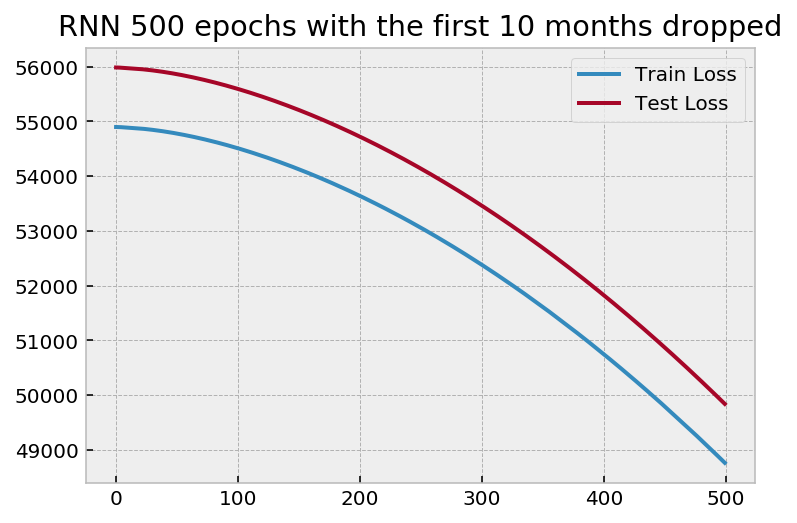

In [19]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.title("RNN 500 epochs with the first 10 months dropped")
plt.legend();

### For this model use early stopping

In [20]:
from time import time

In [19]:
t0 = time()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# time series generator
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 16)

test_seq = TimeseriesGenerator(X_test_sc, 
                                y_test, 
                                length = 3, 
                                batch_size = 16)

# build model
model = Sequential()

model.add(GRU(8, input_shape=(3, 13),
             return_sequences=True))

model.add(GRU(8, 
              return_sequences=False))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', 
               optimizer=Adam(),
               metrics=['mean_absolute_error'])
# early stopping
es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0
)

# fit model
hist = model.fit_generator(train_seq,
                             epochs = 5000,
                             validation_data=test_seq,
                             verbose=0,
                             callbacks=[es])

print(f'This took {round(((time() - t0)/60), 2)} minutes')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
This took 7.18 minutes


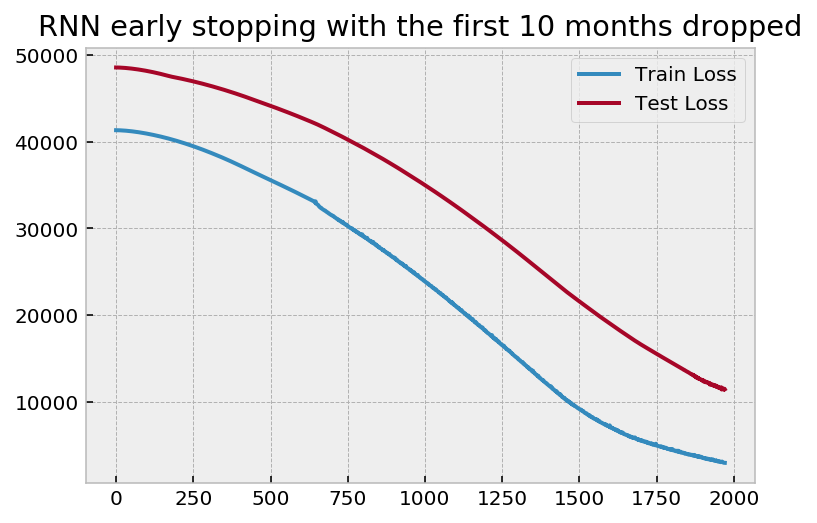

In [20]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.title("RNN early stopping with the first 10 months dropped")
plt.legend();

In [21]:
t0 = time()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# time series generator
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 16)

test_seq = TimeseriesGenerator(X_test_sc, 
                                y_test, 
                                length = 3, 
                                batch_size = 16)

# build model
model = Sequential()

model.add(GRU(8, input_shape=(3, 13),
             return_sequences=True))

model.add(GRU(8, 
              return_sequences=False))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', 
               optimizer=Adam(),
               metrics=['mean_absolute_error'])

# # early stopping
# es = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     min_delta=0
# )

# fit model
hist = model.fit_generator(train_seq,
                             epochs = 2500,
                             validation_data=test_seq,
                             verbose=0)
                             #callbacks=[es])

print(f'This took {(time() - t0)/60} minutes')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
This took 9.003429198265076 minutes


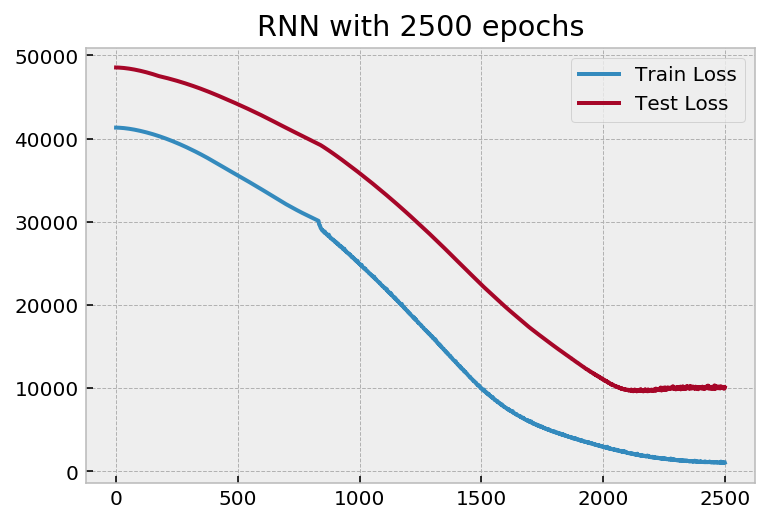

In [22]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.title("RNN with 2500 epochs")
plt.legend();

### try implementing the same model but with early stopping

In [28]:
X = daily.loc[daily.index[290:-1],:].drop(columns='energy_sum')
y = daily.loc[daily.index[290:-1],'energy_sum'].values

In [29]:
t0 = time()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# time series generator
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 16)

test_seq = TimeseriesGenerator(X_test_sc, 
                                y_test, 
                                length = 3, 
                                batch_size = 16)

# build model
model = Sequential()

model.add(GRU(8, input_shape=(3, 13),
             return_sequences=True))

model.add(GRU(8, 
              return_sequences=False))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', 
               optimizer=Adam(),
               metrics=['mean_absolute_error'])

# early stopping
es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0
)

# fit model
hist = model.fit_generator(train_seq,
                             epochs = 3000,
                             validation_data=test_seq,
                             verbose=0,
                             callbacks=[es])

print(f'This took {(time() - t0)/60} minutes')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
This took 5.266569499174754 minutes


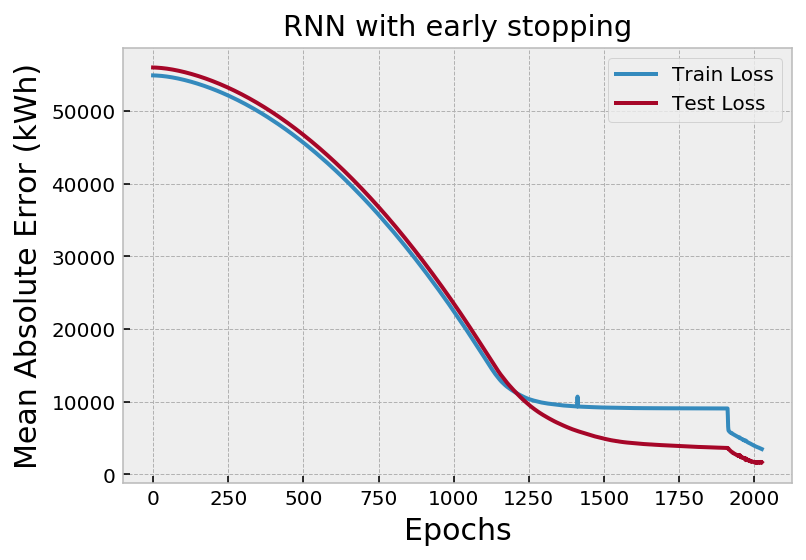

In [56]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.title("RNN with early stopping")
plt.ylabel('Mean Absolute Error (kWh)', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend();

### plot the results

In [31]:
y_preds = pd.DataFrame(model.predict(test_seq))
y_preds['date'] = daily.index[778:-1]
y_preds['energy_sum'] = y_preds[0]
y_preds.drop(columns=0, inplace=True)
y_preds.set_index('date', inplace=True)
y_preds.head()

,energy_sum
date,
2014-01-07,58147.035156
2014-01-08,57568.679688
2014-01-09,57315.601562
2014-01-10,57697.914062
2014-01-11,58087.179688


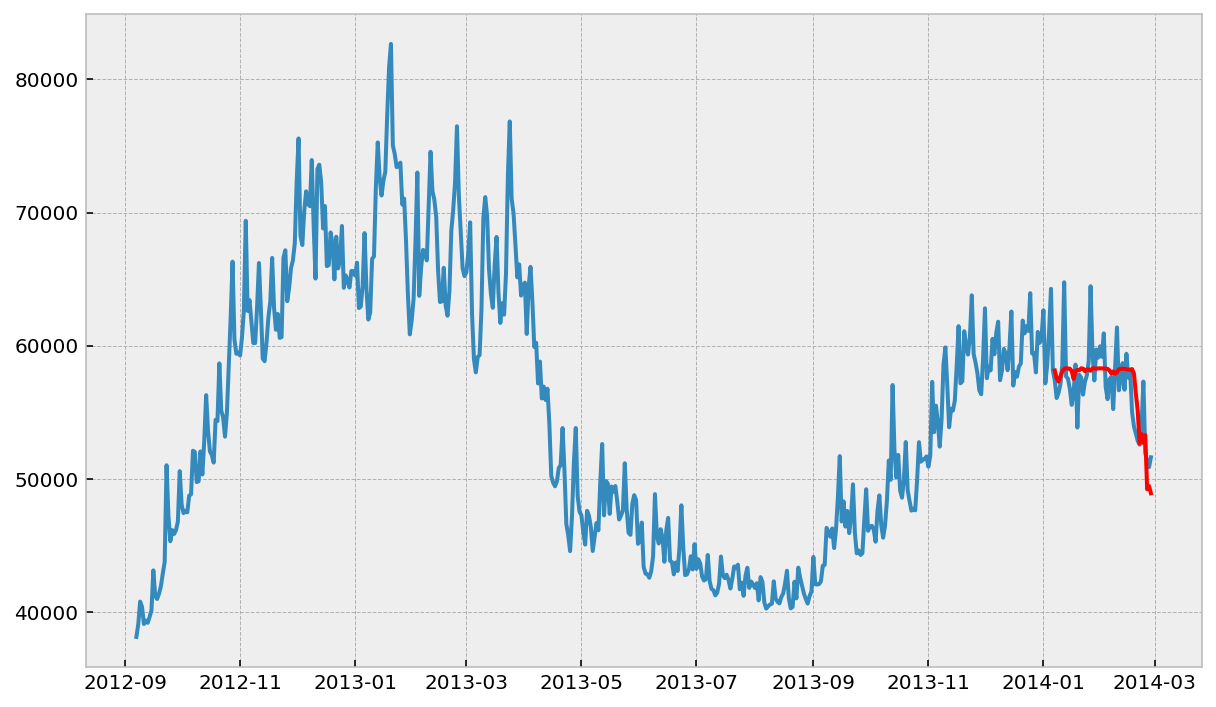

In [46]:
plt.figure(figsize=(10,6))
plt.plot(daily['energy_sum'][290:-1])
plt.plot(y_preds, color='red')

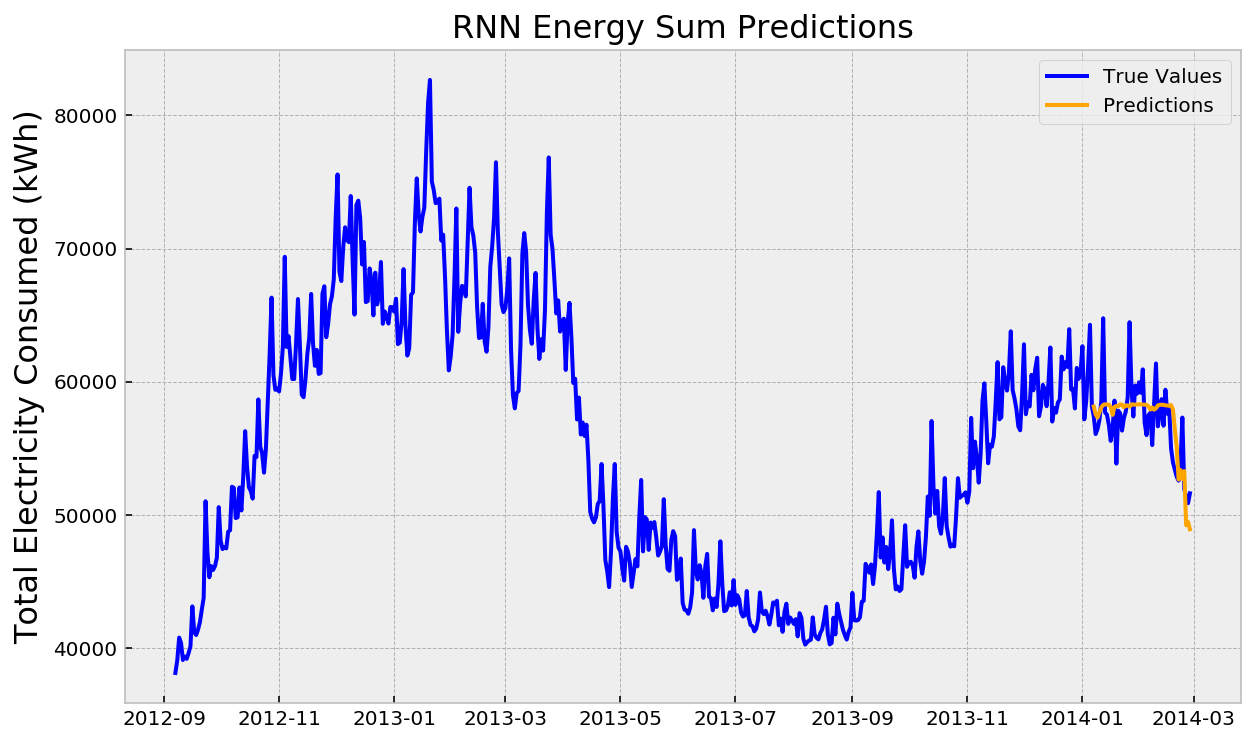

In [54]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(daily.index[290:-1], daily['energy_sum'][290:-1], color = 'blue', label='True Values')

# Plot predicted test data.
plt.plot(y_preds.index, y_preds['energy_sum'], color = 'orange', label = 'Predictions')

plt.title(label = 'RNN Energy Sum Predictions', fontsize=16)
plt.ylabel('Total Electricity Consumed (kWh)', fontsize=16)
#plt.set_facecolor('white')
plt.legend()
plt.show();

In [43]:
from sklearn.metrics import mean_squared_error

In [41]:
y_test[3::].shape

(52,)

In [40]:
y_preds['energy_sum'].shape

(52,)

In [44]:
rmse = np.sqrt(mean_squared_error(y_test[3::], y_preds['energy_sum']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2188.036


#### Test RMSE: 
# 2,188 kWh